# HW 3 Problem 3 (Citibike)
Christopher Prince (cmp670@nyu.edu), using some code from templated file by FBB

9 Oct 2015

In [1]:
import os
import csv
import pylab as pl
import pandas as pd
import numpy as np
import zipfile as zf
from IPython.display import Image

%pylab inline
pd.set_option('max_rows', 21)

Populating the interactive namespace from numpy and matplotlib


## Idea
**Tourists are more likely than residents to ride bikes across an East River bridge.**

Assumptions: 
* We can use determine rides across a bridge by looking at the start and end stations and determining if one is in Manhattan and if the other is in Brooklyn or Queens.
* Riders will ride one way across the bridge and not return to the borough they started in.
* Customers are a proxy for tourists and subscribers are a proxy for residents.

## Null Hypothesis
The ratio of Customers whose journeys begin in Manhattan and end in Brooklyn or Queens (or vice versa) to total Customers $\hat{p}_{C}$ is less than or equal to the same ratio measured for Subscribers $\hat{p}_{S}$.

$$H_{0}: \hat{p}_{C} - \hat{p}_{S} \leq 0$$

## Alternative Hypothesis
The ratio of Customers whose journeys begin in Manhattan and end in Brooklyn or Queens (or vice versa) to total Customers is greater than the same ratio measured for Subscribers.

$$H_{a}: \hat{p}_{C} - \hat{p}_{S} \gt 0$$

## Confidence level
We choose $\alpha = 0.05$.

## Mangling I: Getting the boroughs for each station
First we need to identify the boroughs that the stations are located. It turns out this is not straightforward and I may have picked a pain-in-the-rear idea! But that which does not kill, etc. etc.

I start naively by writing a script that uses the Nominatim API to determine boroughs from a set of coordinates. I collect the coordinates from the citibike station status JSON file. I tweaked it a few times to make it work, including correcting an odd variation where Manhattan's county is alternately reported as "New York County" and simply "New York". The script is in this repository, named `stationborough.py`. The service was fickle, timing out twice before I got it to work, so it is not run in this notebook. The output of the script is also included in this repository, named `stationlist.csv`. Interrogating the csv, I found one error in particular: Nominatim reported that the station at E60th and York Ave was in Queens, which is around the corner from my wife's old office location in Manhattan, so I knew this was incorrect. Going to the Open Street Map (Nominatim's database) I found out why:

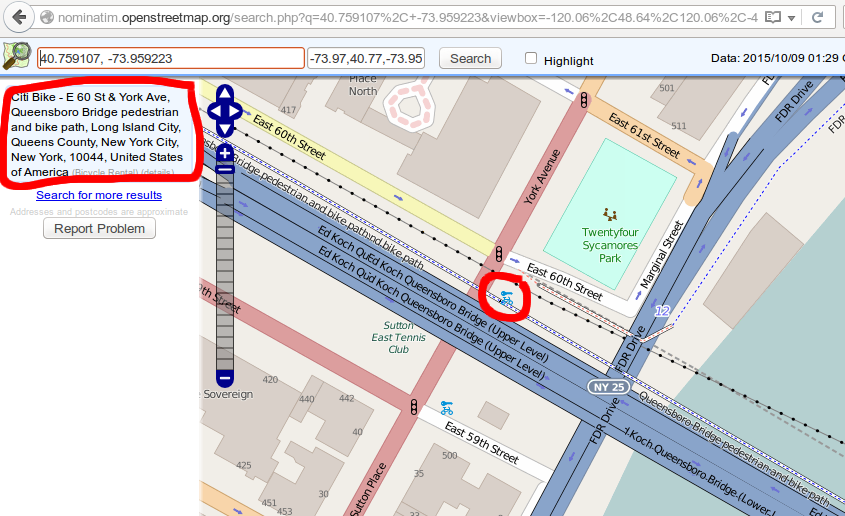

In [2]:
Image(filename = 'cb_station_at_qboro_bike_path_marked.png')

Note that the station appears to be on top of the pedestrian/bike path of the Queensboro bridge. Apparently, this is piece of infrastructure is coded in OSM as belonging to Long Island City, Queens instead of Manhattan. Lacking any better way to fix this, I manually corrected the CSV for station ID 2022. Scanning the county assignments and zip codes reported by Nominatim, there were no other errors that I could detect.

So I thought that was done. I tried to start my analysis by loading the August 2015 data into a pandas dataframe, then merged it with my csv data. Then I noticed NaNs; about 20,000 of them. They were due to stations that were not listed in the JSON status. Fortunately it was easy to find which stations these were:

```
In [14]: pd.Series(df[df['county_x'].isnull()]['start station id']).unique()

Out[14]: array([ 431,  404, 3016,  464, 3014, 3181, 3182,  271, 3133])

In [15]: missingstations = pd.Series(df[df['county_y'].isnull()]['end station id']).unique()

Out[15]: array([ 404,  464, 3016, 3014,  431, 3181, 3182,  271, 3133])
```

`county_x` and `county_y` are the columns from my merged csv identifying the counties the start and end station are in. Fortunately all of the station ids appear to be unique locations (the number of stations is equal to the number of unique latitudes):

```
In [22]: pd.Series(df[df['start station id'].isin(missingstations)]['start station latitude']).unique()

Out[22]: array([ 40.68864636,  40.7405826 ,  40.77105186,  40.75934501,
             40.722852  ,  40.692609  ,  40.686931  ,  40.68522672,  40.76735637])
```

So now we just need to select the coordinates for these IDs, find their counties and add them manually to our csv, then reload the data and remerge. A better solution would be to use a different source for the station data that includes historical or moved stations, but it does not appear that such information is (readily) available.

## Mangling II: Assembling the citibike data

I start by loading the zip file containing the data for August 2015. The data file is located in my ~/data/cb directory, linked to $PUI2015/citibikes/data. In the pandas read_csv call we also restrict the columns to load to the bare minimum needed to address the hypothesis (I'll say that this is for 'performance' reasons, but really I just need a new computer.)

In [3]:
cbcols = ['start station id', 'end station id', 'usertype']
with zf.ZipFile(os.getenv('PUI2015') + '/citibikes/data/201508-citibike-tripdata.zip', 'r') as z:    
    df = pd.read_csv(z.open('201508-citibike-tripdata.csv'), usecols = cbcols)

Next we load the borough data we created in the section above.

In [4]:
sborough = pd.read_csv('stationlist.csv')

We use the `merge` method to bind columns to our data frame `df` from the borough data `sborough`. We join by matching the station id's. I imagine there's a method to drop a redundant id, but it will be good to verify that we used the command correctly. We merge twice, once for the 'start station id' and again for 'end station id'.

In [5]:
df = pd.merge(left=df, right=sborough, how='left', left_on='start station id', right_on='id')
df = pd.merge(left=df, right=sborough, how='left', left_on='end station id', right_on='id')
df

,start station id,end station id,usertype,id_x,county_x,id_y,county_y
0,168,385,Subscriber,168,New York County,385,New York County
1,450,479,Subscriber,450,New York County,479,New York County
2,312,296,Subscriber,312,New York County,296,New York County
3,382,229,Subscriber,382,New York County,229,New York County
4,352,432,Subscriber,352,New York County,432,New York County
5,212,498,Subscriber,212,New York County,498,New York County
6,388,284,Subscriber,388,New York County,284,New York County
7,492,492,Customer,492,New York County,492,New York County
8,387,391,Customer,387,New York County,391,Kings County
9,285,284,Subscriber,285,New York County,284,New York County


The id's match for each of the rows displayed here, so it appears the merges worked as we desired.

Next, create a new dataframe using our criteria for crossing a bridge. Get only rows that:
* have start and end locations in different boroughs (counties)
* where either start or end is in New York County (Manhattan)

We do not include trips between Queens and Kings Counties since those are not rides across the East River! More likely these are hipsters going between Greenpoint and LIC. Not that there's anything wrong with that!

In [6]:
#Get rows for which:
#               [ counties are not the same][that at least one of the counties is New York County (i.e., Manhattan) ]
bridgerides = df[df.county_x != df.county_y][(df.county_x == 'New York County') | (df.county_y == 'New York County')]

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


How frequent are rides across the bridges?

In [7]:
print 'Total rides in Aug 2015: {:>8} \n' \
      'Rides across bridge:     {:>8} ({:.2%})'.format(len(df), len(bridgerides), 1.*len(bridgerides)/len(df))

Total rides in Aug 2015:  1179044 
Rides across bridge:        53399 (4.53%)


A bit fewer than 1 in 20; this doesn't seem like an outrageous number.

Next, we bind a new column to our original dataframe. It will be `True` if the index of the row is also contained in our subset `bridgerides`, otherwise it will be `False`. There's probably a more sophisticated way to do this without needing the intermediary `bridgerides` dataframe, but the syntax proved too tricky, for now.

In [8]:
df['bridge'] = pd.Series(df.index.isin(bridgerides.index))

In [9]:
df

,start station id,end station id,usertype,id_x,county_x,id_y,county_y,bridge
0,168,385,Subscriber,168,New York County,385,New York County,False
1,450,479,Subscriber,450,New York County,479,New York County,False
2,312,296,Subscriber,312,New York County,296,New York County,False
3,382,229,Subscriber,382,New York County,229,New York County,False
4,352,432,Subscriber,352,New York County,432,New York County,False
5,212,498,Subscriber,212,New York County,498,New York County,False
6,388,284,Subscriber,388,New York County,284,New York County,False
7,492,492,Customer,492,New York County,492,New York County,False
8,387,391,Customer,387,New York County,391,Kings County,True
9,285,284,Subscriber,285,New York County,284,New York County,False


This worked as we wanted it to: the fifth row from the end (index 1179039 indicating a ride from Queens to Brooklyn) is False, rides within the same county are False, and rides from Manhattan to another borough are True.

## Plots

Okay, let's plot. Our numbers are quite large, so the error bars are nearly invisible.

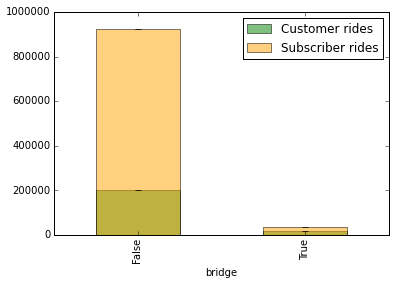

In [10]:
counts_c = df['bridge'][df.usertype == 'Customer'].groupby(df['bridge']).count()
error_c = np.sqrt(counts_c)
counts_s = df['bridge'][df.usertype == 'Subscriber'].groupby(df['bridge']).count()
error_s = np.sqrt(counts_s)

counts_c.plot(kind = 'bar', yerr = [error_c, error_c], color='green', alpha=0.5, label = 'Customer rides')
ax = counts_s.plot(kind = 'bar', yerr = [error_s, error_s], color='orange', alpha=0.5, label = 'Subscriber rides')
ax.legend()

We also want to see the proportions of rides, so we normalize with respect to the total counts for each `usertype`.

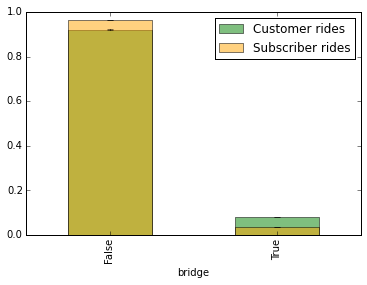

In [11]:
norm_c = counts_c.sum()
norm_s = counts_s.sum()

((counts_c)/norm_c).plot(kind = 'bar', yerr = [(error_c)/norm_c, (error_c)/norm_c], 
                         color='green', alpha=0.5, label = 'Customer rides')
ax = ((counts_s)/norm_s).plot(kind = 'bar', yerr = [(error_s)/norm_s, (error_s)/norm_s], 
                              color='orange', alpha=0.5, label = 'Subscriber rides')
ax.legend()

## $z$-test

Now, we calculate the relative proportions and errors for the terms we need to evaluate our null hypothesis, $\hat{p}_{C}$ and $\hat{p}_{S}$ (in the code, this is `bridge_c` and `bridge_s`.)

0.080530869337 0.919469130663 0.000603655257073 0.00203974731482
0.0371609773206 0.962839022679 0.000196947253745 0.00100249729025
0.080530869337 0.0371609773206 0.0452900824736 0.000490700429638 88.3836438628


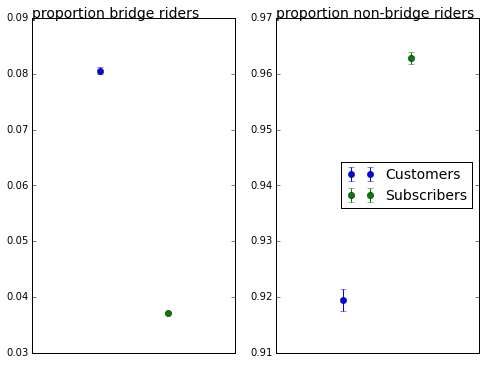

In [12]:
fig = pl.figure(figsize(8,6))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)
ax1.set_xticks([])
ax2.set_xticks([])
bridge_c = counts_c[True]*1.0/norm_c
nobridge_c = counts_c[False]*1.0/norm_c
errbridge_c = error_c[True]*1.0/norm_c
errnobridge_c = error_c[False]*1.0/norm_c

bridge_s = counts_s[True]*1.0/norm_s
nobridge_s = counts_s[False]*1.0/norm_s
errbridge_s = error_s[True]*1.0/norm_s
errnobridge_s = error_s[False]*1.0/norm_s

print bridge_c, nobridge_c, errbridge_c, errnobridge_c
print bridge_s, nobridge_s, errbridge_s, errnobridge_s

ax1.errorbar([0.2],[bridge_c], yerr=[errbridge_c], fmt='o', label='Customers')
ax1.errorbar([0.4],[bridge_s], yerr=[errbridge_s], fmt='o', label='Subscribers')
ax1.text(0, 1, 'proportion bridge riders', transform = ax1.transAxes, size = 14)
ax1.set_xlim(0,0.6)
ax2.errorbar([0.2],[nobridge_c], yerr=[errnobridge_c], fmt='o', label='Customers')
ax2.errorbar([0.4],[nobridge_s], yerr=[errnobridge_s], fmt='o', label='Subscribers')
ax2.text(0, 1, 'proportion non-bridge riders', transform = ax2.transAxes, size = 14)
ax2.set_xlim(0,0.6)
pl.legend(loc='best', fontsize = 14)

p = (bridge_c*norm_c + bridge_s*norm_s)*1.0/ (norm_c + norm_s)
SE = np.sqrt(p * ( 1. - p ) * ( (1./norm_c) + (1./norm_s) ) )
z = (bridge_c - bridge_s ) / SE
print bridge_c, bridge_s, p,SE,z

What is the difference in proportions $\hat{p}_{C} - \hat{p}_{S}$?

In [13]:
Pc_Ps = bridge_c - bridge_s
print Pc_Ps

0.0433698920164


Already this looks significant (and our error bars, such as they are, seem to support that observation). Let's calculate the $z$-score:

In [14]:
sp_stdev= lambda p0, n1: np.sqrt(p0*(1-p0)/n1)
sp_stdev_cs=sp_stdev(bridge_c,norm_s)

zscore = lambda p0, p1, s : (p0-p1)/s
z = zscore(bridge_c, bridge_s, sp_stdev_cs)
print z 

156.002732292


It is not necessary to check a table to determine that a value 156 standard deviations away has statistical significance! **Thus we reject the null hypothesis. If our assumptions hold, this implies that tourists *are* more likely to ride across the East River bridges than residents!** 

### $\chi^{2}$ test

Now let's use the $\chi^{2}$ test. To fill in the contingency table, we need to recall the counts for each of the four cells of the table:

In [15]:
print 'customers:\n', counts_c, '\n'*2, 'subscribers:\n', counts_s

customers:
bridge
False    203199
True      17797
Name: bridge, dtype: int64 

subscribers:
bridge
False    922446
True      35602
Name: bridge, dtype: int64


| Rode across the bridge:   |     True   | False   |                   total
|---------------------------|----------------|------------------|---------------------------|
| Customers                 |  17797  |  203199    | 220996                       |
| Subscribers               |  35602  |  922446    | 958048                       |
|                           |                |                  |                           |
| total                     |  53399      |  1125645         | **1178964**         |

Now we calculate $\chi^{2}$ using the formula for a 2 $\times$ 2 contingency table:

In [16]:
Ntot = 1178964
expected = 53399*1125645*220996*958048*1.0
sample_values = [[17797,203199],[35602,922446]]

chisqstat= lambda N, values, expect : N*((values[0][0]*values[1][1]-values[0][1]*values[1][0])**2)/(expect)

print chisqstat(Ntot,  sample_values, expected)

7811.1384684


This value is much, much larger than the $df = 1, \alpha = 0.05$ value of 3.84, so **we can (again) reject the null hypothesis.**

We can confirm this calculation using the built-in scipy.stats function:

In [17]:
from scipy.stats import chi2_contingency
chi2_contingency([[counts_c[True], counts_c[False]],[counts_s[True],counts_s[False]]])[0]

7810.6655049515166

## What about other months?

We can use the built-in function to loop through a series of files containing the data for other months in 2015 and calculate different values of $\chi^{2}$ for each.

In [18]:
for i in range(1,10):
    with zf.ZipFile(os.getenv('PUI2015') + '/citibikes/data/20150%i-citibike-tripdata.zip'%(i), 'r') as z:    
        df = pd.read_csv(z.open('20150%i-citibike-tripdata.csv'%(i)), usecols = cbcols)
    
    df = pd.merge(left=df, right=sborough, how='left', left_on='start station id', right_on='id')
    df = pd.merge(left=df, right=sborough, how='left', left_on='end station id', right_on='id')
    bridgerides = df[df.county_x != df.county_y][(df.county_x == 'New York County') | (df.county_y == 'New York County')]
    df['bridge'] = pd.Series(df.index.isin(bridgerides.index))
    counts_c = df['bridge'][df.usertype == 'Customer'].groupby(df['bridge']).count()
    counts_s = df['bridge'][df.usertype == 'Subscriber'].groupby(df['bridge']).count()
    print 'month: %i   chi2: %s'%(i, chi2_contingency([[counts_c[True], counts_c[False]],[counts_s[True],counts_s[False]]])[0])

month: 1   chi2: 727.727798247
month: 2   chi2: 320.803207124
month: 3   chi2: 1714.70076822
month: 4   chi2: 6030.30338165
month: 5   chi2: 9283.97841063
month: 6   chi2: 5591.04751032
month: 7   chi2: 5630.81143608
month: 8   chi2: 7810.66550495
month: 9   chi2: 6064.50403927


The result remains significant to our chosen level of $\alpha = 0.05$ even in the winter months, although the values of $\chi^{2}$ are much lower in January, February and March.

## Postscript

Why did I hardcode the values in my $\chi^{2}$ test instead of using the values in `counts_c` and `counts_s`? Well, I tried this in another notebook with another data set. Let's take a look at what happened when I tried this:

```
In [17]:    Ntot_val = counts_c.sum() + counts_s.sum()
            expected_val = counts_c.sum() * counts_s.sum() * (counts_c[True] + counts_s[True]) * \
               (counts_c[False] + counts_s[False]) * 1.
            sample_values_val = [[counts_c[True],counts_c[False]],[counts_s[True],counts_s[False]]]
            print chisqstat(Ntot_val,  sample_values_val, expected_val)

Out [17]:   -35.7126711746
```
Try it yourself, and see if you get the same result!

In [19]:
Ntot_val = counts_c.sum() + counts_s.sum()
expected_val = counts_c.sum() * counts_s.sum() * (counts_c[True] + counts_s[True]) * (counts_c[False] + counts_s[False]) *1.
sample_values_val = [[counts_c[True],counts_c[False]],[counts_s[True],counts_s[False]]]
print chisqstat(Ntot_val,  sample_values_val, expected_val)

-35.7126711746


The variables `Ntot_val` and `sample_values_val` seem to be the same as the hard coded values above, but `exptected_val` does *not*:
```
In [19]:    print Ntot_val, sample_values_val
            print expected, expected_val

Out [19]:   1289699 [[16090, 194017], [41326, 1038266]]
            1.27264200162e+22 1.6979269112e+17
```

In [20]:
print Ntot_val, sample_values_val
print expected, expected_val

1289699 [[16090, 194017], [41326, 1038266]]
1.27264200162e+22 1.6979269112e+17


This is unexpected. The terms in the calculation of `expected_val` are what we expect.

In [21]:
print counts_c.sum(), counts_s.sum(), (counts_c[True] + counts_s[True]), (counts_c[False] + counts_s[False])

210107 1079592 57416 1232283


This feels like an error from type conversion, but I haven't been able to figure this one out. It is possible that I have a hardware issue (working on a laptop equipped with a cheap AMD processor). So, if you have any ideas (or if your notebook evaluates the cells above as I would have expected them) I'd be happy to hear it!